# TF2 Demo Analysis

*(Be sure to select the .env kernal!)*

Analysis of a `.dem` file.

## Imports

The library itself requires [`numpy`](https://numpy.org/), and this analysis file
requires `pandas` for data frames, `matplotlib` for graphs (including `ipympl`), and `kmapper` for the
topological data analysis via Mapper. All of these can be easily installed via `pip`:

`!pip install --upgrade numpy matplotlib ipympl pandas pyarrow kmapper`

### Conventions

Variables that are meant to be used in multiple different code blocks are written
`IN_CAPITAL_SNAKE_CASE` just like constants, and should typically be used as if
they were constants.

Other variables are OK to be written over in each different code block.

In [1]:
## Imports
%matplotlib widget

# The library generated by rust
import tf2dal as dal

# Pylance may mark these as unresolved imports; ignore this, it should still
# resolve. It's probably just confused as they're .pyi files
from tf2dal import entities as ent, events as evt, game, math, demo

# If any of these fail, use "!pip install <package>" to install via pip
# Importing may take a while (especially for pandas)
import numpy as np
import pyarrow # for pandas 3.0
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import kmapper as km

import sys
if sys.version_info < (3, 10):
    print(f"ERROR: This script requires Python version 3.10 or higher.")
    exit(-1)

print(f"Running on Python version {sys.version}")

Running on Python version 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]


In [2]:
## Logging

import logging
LOGGING_FMT = '%(levelname)s %(name)s %(filename)s:%(lineno)d %(message)s'
logging.basicConfig(format=LOGGING_FMT)
logging.getLogger().setLevel(logging.INFO)

Information for `demos/demofile.dem`:
- Acquired from [demos.tf/1042159](https://demos.tf/1042159) 
- Associated log at [logs.tf/3501742](https://logs.tf/3501742)

Round data for demofile.dem should be approximately as follows (from log):

If loading this demofile, make sure the information is (at least approximately) correct!

| Round | Time | Kills | Winner |
|-------|------|-------|--------|
| 0     | 3:37 | 19    | Red    |
| 1     | 2:41 | 21    | Red    |
| 2     | 8:23 | 47    | Blue   |
| 3     | 2:05 | 9     | Red    |
| 4     | 2:17 | 23    | Red    |
| 5     | 4:34 | 33    | Red    |

In [3]:
# Load the demo into rounds and give a quick summary
# Demo file loading is supposed to give output, but print statements from
# Rust are not printed out to the notebook as they are printed to stdout.

# The data for the entire demo file may be over a gigabyte, so do take caution!
DEMO_ROUND_LIST_RAW = dal.load_demo_rounds("demos/demofile.dem")
print(f"Loaded {len(DEMO_ROUND_LIST_RAW)} round(s)")

for i, round in enumerate(DEMO_ROUND_LIST_RAW):
    time = 0.0
    for tick, state in round.tick_states.items():
        time += state.tick_delta
    print("Round %d: %2d:%5.2f (%f) | %2d Kills | %5d States | %5d Ticks | Winner: %s" % (
        i, int(np.floor(time/60)), time - np.floor(time/60) * 60, time,
        len(round.kills),
        len(round.tick_states),
        round.rounds[0].end_tick - round.rounds[0].start_tick,
        round.rounds[0].winner
    ))

INFO tf2dal.app app.rs:18 Single threaded parse!
INFO tf2dal.app app.rs:26 ("demofile.dem") Max Ticks: 98808
INFO tf2dal.app app.rs:36 ("demofile.dem") 5%
INFO tf2dal.app app.rs:36 ("demofile.dem") 10%
INFO tf2dal.app app.rs:36 ("demofile.dem") 15%
INFO tf2dal.app app.rs:36 ("demofile.dem") 20%
INFO tf2dal.app app.rs:36 ("demofile.dem") 25%
INFO tf2dal.app app.rs:36 ("demofile.dem") 30%
INFO tf2dal.app app.rs:36 ("demofile.dem") 35%
INFO tf2dal.app app.rs:36 ("demofile.dem") 40%
INFO tf2dal.app app.rs:36 ("demofile.dem") 45%
INFO tf2dal.app app.rs:36 ("demofile.dem") 50%
INFO tf2dal.app app.rs:36 ("demofile.dem") 55%
INFO tf2dal.app app.rs:36 ("demofile.dem") 60%
INFO tf2dal.app app.rs:36 ("demofile.dem") 65%
INFO tf2dal.app app.rs:36 ("demofile.dem") 70%
INFO tf2dal.app app.rs:36 ("demofile.dem") 75%
INFO tf2dal.app app.rs:36 ("demofile.dem") 80%
INFO tf2dal.app app.rs:36 ("demofile.dem") 85%
INFO tf2dal.app app.rs:36 ("demofile.dem") 90%
INFO tf2dal.app app.rs:36 ("demofile.dem") 95%

Loaded 6 round(s)
Round 0:  3:36.45 (216.449995) | 19 Kills | 14430 States | 14434 Ticks | Winner: Team.Red
Round 1:  2:41.74 (161.744996) | 21 Kills | 10783 States | 10785 Ticks | Winner: Team.Red
Round 2:  8:22.24 (502.244989) | 47 Kills | 33483 States | 33485 Ticks | Winner: Team.Blue
Round 3:  2: 5.23 (125.234997) |  9 Kills |  8349 States |  8352 Ticks | Winner: Team.Red
Round 4:  2:15.75 (135.749997) | 23 Kills |  9050 States |  9135 Ticks | Winner: Team.Red
Round 5:  4:32.52 (272.519994) | 33 Kills | 18168 States | 18277 Ticks | Winner: Team.Red


### Helper functions

In [4]:
def team_to_int(team: game.Team):
    return np.uint8(team)

def class_to_int(player_class: game.Class | np.uint8):
    return np.uint8(player_class)

# If you want to print out a player's class or team,
# you can convert them back to the enum variant:
# >>> game.Team(team_number)
# or
# >>> game.Class(class_number)

def tsld_to_critperc(time_since_last_damage: float):
    """TSLD = Time Since Last Damage, in seconds.
    Heal rate from the medigun has a base of 24 hp/s, which occurs
    if the patient has taken damage within the past 10 seconds.
    If it's been 15 or more seconds since then, the patient gets healed
    for 72 hp/s (three times!) instead.
    Heal rate scales linearly between 10 and 15 seconds."""
    return max(0, min(1, (time_since_last_damage - 10.0) / 5.0))

## Conversion to Data Frames

Round data by itself is difficult to work with, so here we convert the data into
data frames for each round.

When accessing a column, DO NOT use an actual string! Use the constants!

Currently, the data table has the following data per tick, per player:

| Column Name   | Description |
|-------------  |-------------|
| `TICK`        | The game tick number. While each tick is an integer (`334`, `335`, ...), they are approximately 0.015 seconds apart. |
| `USER_ID`     | The ID number of the player |
| `TEAM`        | Team number. `2` is Blue team, `3` is Red team. Anything else is not a playable team.|
| `CLASS`       | The class. Check `tf2dal.game.Class` for enumerations. |
| `ALIVE`       | If the player is alive or not. `0` is dead, `1` is alive. |
| `HEALTH`      | The player's current health. |
| `XPOS`        | The player's position on the X axis. |
| `YPOS`        | The player's position on the Y axis. |
| `ZPOS`        | The player's position on the Z axis. |
| `CRIT_PERC`   | "Critheal Percent." If at 0, the player WOULD be getting healed for 24 health per second by the medic. At 1, they are healed at 72 hp/s. This is called "crit heals," and this is it as a percentage. |
| `BEING_HEALED` | 0 if not being healed. If they are, then it is the user id of the medic. |

In [5]:
USER_ID = "USER_ID"
TEAM = "TEAM"
CLASS = "CLASS"
ALIVE = "ALIVE"
HEALTH = "HEALTH"
XPOS = "X_POS"
YPOS = "Y_POS"
ZPOS = "Z_POS"
CRIT_PERC = "CRIT_PERC"
BEING_HEALED = "BEING_HEALED"

TIME = "TIME"
TICK = "TICK"

PLAYERDF_COLUMNS = [
    TICK,
    USER_ID,
    TEAM,
    CLASS,
    ALIVE,
    HEALTH,
    CRIT_PERC,
    BEING_HEALED,
    XPOS,
    YPOS,
    ZPOS,
]

# Used for finding the index of a column, e.g. COLUMN_INDEX[TICK] should give 0.
COLUMN_INDEX = {col:dex for (dex, col) in enumerate(PLAYERDF_COLUMNS)}

def player_to_attr_list(player: ent.Player):
    l = [
        0,  # Expected to be filled out by the DF creation
        player.info.user_id or 9999,
        player.team,
        player.player_class,  # convert to value
        player.is_alive(),
        player.health,
        tsld_to_critperc(player.time_since_last_hurt),
        0,  # Expected to be filled out by the DF creation
        player.position.x,
        player.position.y,
        player.position.z,
    ]
    assert(len(l) == len(PLAYERDF_COLUMNS))
    return l

In [6]:
def construct_round_dataframe(round: demo.DemoData):
    rowlist = []
    for (tick, tickdata) in round.tick_states.items():
        # 1: Find who is being healed by a medic.
        entid_to_uid = { player.info.entity_id: player.info.user_id for player in tickdata.players if player.info }

        # being_healed:
        # k: who is being healed
        # v: who is doing the healing
        being_healed = {}
        for medigun in tickdata.mediguns:
            if medigun.is_healing and medigun.heal_target > 0:
                try:
                    being_healed[entid_to_uid[medigun.heal_target]] = entid_to_uid[medigun.owner]
                except KeyError:
                    print(f"Medigun is healing invalid target ({medigun.heal_target}).\nEnt_to_uid: {entid_to_uid}")
                    pass

        # 2. Construct player data
        for player in tickdata.players:
            if not player.team.is_player():
                continue
            player_attr_list = player_to_attr_list(player)
            userid = player_attr_list[COLUMN_INDEX[USER_ID]]
            player_attr_list[COLUMN_INDEX[TICK]] = tick - round.rounds[0].start_tick
            if userid in being_healed:
                player_attr_list[COLUMN_INDEX[BEING_HEALED]] = being_healed[userid]
            
            #print(f"Appending {player_attr_list}")
            rowlist.append(player_attr_list)
    
    return pd.DataFrame(rowlist, columns=PLAYERDF_COLUMNS).sort_values(by=TICK, ignore_index=True)

In [7]:
# ROUND

CUR_ROUND = 0
ROUND_DF = construct_round_dataframe(DEMO_ROUND_LIST_RAW[CUR_ROUND])

In [8]:
ROUND_NUMBER_DF = ROUND_DF.copy() # deep copy
ROUND_NUMBER_DF[TEAM] = ROUND_NUMBER_DF[TEAM].map(team_to_int)
ROUND_NUMBER_DF[CLASS] = ROUND_NUMBER_DF[CLASS].map(class_to_int)

In [9]:
ROUND_NUMBER_DF

,TICK,USER_ID,TEAM,CLASS,ALIVE,HEALTH,CRIT_PERC,BEING_HEALED,X_POS,Y_POS,Z_POS
0,0,3,3,1,True,125,1.0,0,-4816.000,-1280.000,576.000000
1,0,14,2,1,True,125,1.0,0,4752.000,1376.000,576.000000
2,0,13,2,4,True,175,1.0,0,4752.000,1184.000,576.000000
3,0,12,2,3,True,200,1.0,0,4704.000,1280.000,576.000000
4,0,11,2,3,True,200,1.0,0,4864.000,1344.000,576.000000
...,...,...,...,...,...,...,...,...,...,...,...
173155,14434,11,2,3,True,228,0.0,0,-2816.375,-1500.375,576.031128
173156,14434,12,2,3,True,181,0.0,0,-3280.375,-2377.000,576.000000
173157,14434,13,2,4,True,234,0.0,0,-3318.750,-1012.875,511.375000
173158,14434,4,3,5,True,150,1.0,0,-3981.625,-918.750,783.500000


In [10]:
ROUND_DF.melt([TICK, USER_ID], value_vars=[XPOS, YPOS]).groupby([TICK, USER_ID])['value'].mean()

TICK   USER_ID
0      3         -3048.0000
       4         -3040.0000
       5         -3104.0000
       6         -2992.0000
       7         -2968.0000
                    ...    
14434  10        -2198.0000
       11        -2158.3750
       12        -2828.6875
       13        -2165.8125
       14        -1559.3750
Name: value, Length: 173160, dtype: float64

In [12]:
# As tickdelta ~= 0.015s, one second is approximately 66.6 ticks
# So we're gonna average each person's position over each second

alive_df = ROUND_DF[ROUND_DF[ALIVE] > 0]

alive_df.loc[0:66*12].melt([TICK, USER_ID], value_vars=[XPOS])

,TICK,USER_ID,variable,value
0,0,3,X_POS,-4816.000
1,0,14,X_POS,4752.000
2,0,13,X_POS,4752.000
3,0,12,X_POS,4704.000
4,0,11,X_POS,4864.000
...,...,...,...,...
788,69,14,X_POS,4752.000
789,69,3,X_POS,-4816.000
790,69,6,X_POS,-4703.625
791,69,5,X_POS,-4864.000


In [13]:
uid_means = []
for uid in range(3, 15):
    # 1. This is supposed to go per user, so we only want the specific
    # user we're on right now
    # 2. We only want their position from when they were alive
    # 3. Team & class 
    uid_means.append(ROUND_NUMBER_DF[
        (ROUND_NUMBER_DF[USER_ID] == uid)
        & (ROUND_NUMBER_DF[ALIVE] > 0)
        ].reset_index(drop=True).rolling(66, step=66).mean())

In [14]:
uid_means[1]

,TICK,USER_ID,TEAM,CLASS,ALIVE,HEALTH,CRIT_PERC,BEING_HEALED,X_POS,Y_POS,Z_POS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,37.5,4.0,3.0,5.0,1.0,150.0,1.0,0.0,-4864.000000,-1216.000000,576.000000
132,103.5,4.0,3.0,5.0,1.0,150.0,1.0,0.0,-4864.000000,-1216.000000,576.000000
198,169.5,4.0,3.0,5.0,1.0,150.0,1.0,0.0,-4864.000000,-1216.000000,576.000000
264,235.5,4.0,3.0,5.0,1.0,150.0,1.0,0.0,-4864.000000,-1216.000000,576.000000
...,...,...,...,...,...,...,...,...,...,...,...
12804,14082.5,4.0,3.0,5.0,1.0,150.0,1.0,0.0,-4176.142045,-1777.659091,768.031311
12870,14148.5,4.0,3.0,5.0,1.0,150.0,1.0,0.0,-4153.795455,-1603.844697,768.031311
12936,14214.5,4.0,3.0,5.0,1.0,150.0,1.0,0.0,-4141.647727,-1518.683712,768.031311
13002,14280.5,4.0,3.0,5.0,1.0,150.0,1.0,0.0,-4137.736742,-1486.585227,768.031311


In [ ]:

TICKS_PER_SECOND = 66

mean_df = pd.DataFrame(columns=PLAYERDF_COLUMNS);
for second in range(10):
    mean: pd.DataFrame = ROUND_DF[
        (ROUND_DF[TICK] >= second*TICKS_PER_SECOND) 
        & (ROUND_DF[TICK] < (second+1)*TICKS_PER_SECOND) 
        & (ROUND_DF[ALIVE] > 0)
        ].loc[:, ~ROUND_DF.columns.isin([TEAM, CLASS])
          ].groupby(USER_ID).mean()
    
    mean.

In [ ]:
ROUND_DF.value_counts(subset=[USER_ID, TEAM, CLASS], sort=False)
#[[USER_ID, TEAM, CLASS]].

In [ ]:
first_tick = ROUND_DF[ROUND_DF[TICK] < 10000]

In [16]:
redteam_df = ROUND_NUMBER_DF[ROUND_NUMBER_DF[TEAM] == 2]
bluteam_df = ROUND_NUMBER_DF[ROUND_NUMBER_DF[TEAM] == 3]

In [20]:
redteam_df[TICK].max()

14434

In [ ]:
from sklearn.cluster import DBSCAN

scan = DBSCAN(eps=540, min_samples=1) # single player

def tick_clusters(df: pd.DataFrame):
    # df is a data frame that has only one value for tick
    scan.fit()

def team_clusters(df: pd.DataFrame):
    max_tick = df[TICK].max()
    for tick in range(max_tick + 1):
        

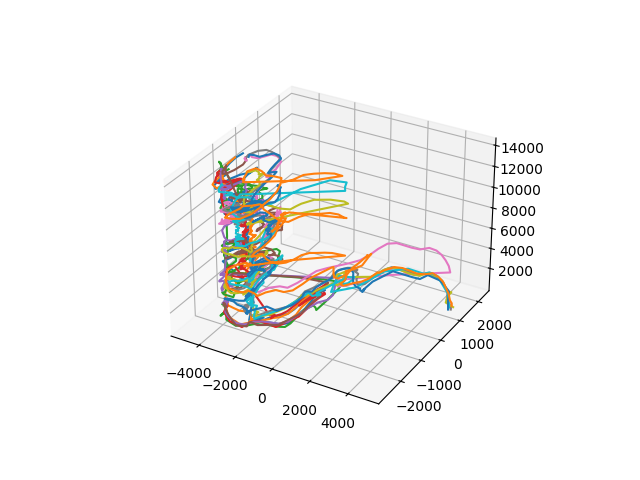

In [15]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure()
ax: Axes3D = fig.add_subplot(111, projection='3d')

for i in range(len(uid_means)):
    ax.plot(xs=uid_means[i][XPOS].values, ys=uid_means[i][YPOS].values, zs=uid_means[i][TICK].values)
#ax.scatter(xs=uid3_means[XPOS].values, ys=uid3_means[YPOS].values, zs=uid3_means[TICK].values, s=2)

In [ ]:
ROUND_DF[ROUND_DF[BEING_HEALED] > 0].value_counts(subset=[USER_ID, TEAM, CLASS, BEING_HEALED], sort=False)

### Player, Tick, and Round Summaries.

Player summary: 

todo

Team Summary:

| Column | Description |
|--------|-------------|
| `IS_TICK` | If this summary is only data on a single tick. Otherwise, it is either the average or the median over multiple ticks. |
| `TEAM` | Which team is this describing |
| `

Tick Summary:
| Column | Description |
|--------|-------------|
| 

In [ ]:
def create_tick_summary(tick: demo.TickData):
    

### Basic Analysis: Player and Round Summaries

This section offeres a summary of data for each player on each round, including some round-specific data.

In [ ]:
# Data summaries
class PlayerSummary:
    def __init__(self):
        self.kills = 0
        self.assists = 0
        self.deaths = 0
        self.captures = 0
        self.ticks_dead = 0
        self.ticks_alive = 0

### KMapper: Mapping Player Positions

The goal of this section is to be able to graph different "groupings" of players.

1. Get data
    
    Data has the following 6 axes:
    4. Time (in seconds) since the start of the round
    1. X Axis
    2. Y Axis
    3. Z Axis
    1. User ID
    5. Player Status (alive/dead)

2. Initialize

3. Project data - XYZ axis?

    `projected_data = mapper.fit_transform(data, projection=[0,1]) # X-Y axis`

4. Create a cover 

    `cover = km.Cover(n_cubes=10)`

5. Graph

    `graph = mapper.map(projected_data, data, cover=cover)`

6. Visualize

    `mapper.visualize(graph, path_html="make_circles_keplermapper_output.html",
                 title="make_circles(n_samples=5000, noise=0.03, factor=0.3)")`

In [21]:
mapper = km.KeplerMapper(verbose = 2)

KeplerMapper(verbose=2)


In [ ]:
round0_df = construct_round_dataframe(rounds_data[0])

In [ ]:
vars(game.Class)

## Findind some interesting tick-based statistics

Table Columns:
 - Tick
 - RED Alive
 - BLU Alive

In [ ]:
game.Class(0).name

In [ ]:
## Filter out unneccesary data

print(round0_df.shape)

# userid 2 is typically sourcetv - we can ignore them
round0_df = round0_df[round0_df[USER_ID] != 2]
print(round0_df.shape)

# only want living players
round0_df = round0_df[round0_df[ALIVE] > 0]
print(round0_df.shape)

# Typical tick rate is 66 and 2/3 ticks per second
# or tick delta is usually 
# concat: for each user, 


In [ ]:
for tick in rounds_data[0].tick_states:
    print([(p.info.name, p.info.user_id) for p in rounds_data[0].tick_states[tick].players])
    break

In [32]:

main_data_column_names = [TICK, CLASS, USER_ID, XPOS, YPOS]
main_data = redteam_df[main_data_column_names].reset_index(drop=True)

project_to_axes_names = [XPOS, YPOS]#, "Time(s)"
project_to_axes = [main_data.axes[1].get_loc(x) for x in project_to_axes_names] # , 'XPos', 'YPos'

projected_data = mapper.fit_transform(
    main_data.values,
    projection=project_to_axes,
    scaler=None #don't scale the positional data
)

..Composing projection pipeline of length 1:
	Projections: [3, 4]
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (86580, 5)

..Projecting data using: [3, 4]


In [25]:
projected_data

array([[-4816.0, -1280.0],
       [4704.0, 1280.0],
       [4864.0, 1344.0],
       ...,
       [-3683.25, -1099.25],
       [-3981.625, -918.75],
       [-1506.0, -1612.75]], dtype=object)

In [ ]:
tttttt = (rounds_data[0].player_reach_bounds.bound_max.xy()
      - rounds_data[1].player_reach_bounds.bound_min.xy()) / 1000.0
print(f"{tttttt.x}, {tttttt.y}, {tttttt.dot(tttttt)/2}")

In [ ]:
main_data.UserId.value_counts()

Playing around with number of cubes per dim:

Runtime for 250,000 hypercubes with 4 axes was ~15 minutes
Runtime for 50 cubes / 1 axis / eps of 10 was >9 minutes

- 10x7 X/Y cubes, 22 time cubes, overlap of .3, .5, .5 respectively:
  - eps of 100 & min of 10 gave:
    - 1540 hypercubes
    - 15692 edges and 2236 nodes (holy shit)
    - all in approx. 3:20s
    - visuaizer was 16 MB
  - eps of 10 and min of 5 gave:
    - way tooo fuckin many clusters ????
    - 35686 edges and 11044 clusters
  - eps of 10 and min of 60:
    - 62 edges and 20 nodes!

Maybe want to look at different clustering algorithms?

In [33]:
import sklearn.cluster as clust

# Cubes in time should be about 10 seconds long
# Cubes in space should be about 600 wide with 50% overlap

time_cube_count = int(np.ceil(main_data[TICK].max() / 10.0))
per_dim_count = (DEMO_ROUND_LIST_RAW[CUR_ROUND].player_reach_bounds.bound_max
      - DEMO_ROUND_LIST_RAW[CUR_ROUND].player_reach_bounds.bound_min) / 1000.0

xy_cube_cover = (int(np.ceil(per_dim_count.x)), int(np.ceil(per_dim_count.y)))#int(np.ceil(per_dim_count.x * per_dim_count.y / 2.0))

print(f"Time Cubes: {time_cube_count}")
print(f"XY Cubes: {xy_cube_cover}")

cover = km.Cover(
    # Cubes for Time, then X/Y Position
    n_cubes=[int(np.ceil(per_dim_count.x)), int(np.ceil(per_dim_count.y))],
    perc_overlap=[0.5, 0.5]
)
#sklearn.metrics
clusterer = clust.DBSCAN(eps=540, min_samples=1)

graph = mapper.map(projected_data, main_data.values, cover=cover, clusterer=clusterer)

Time Cubes: 1444
XY Cubes: (10, 7)
Mapping on data shaped (86580, 5) using lens shaped (86580, 2)

Minimal points in hypercube before clustering: 1
Creating 70 hypercubes.
   > Found 5 clusters in hypercube 0.
   > Found 6 clusters in hypercube 1.
   > Found 8 clusters in hypercube 2.
   > Found 3 clusters in hypercube 3.
   > Found 2 clusters in hypercube 4.
   > Found 3 clusters in hypercube 5.
   > Found 5 clusters in hypercube 6.
   > Found 4 clusters in hypercube 7.
   > Found 3 clusters in hypercube 8.
   > Found 2 clusters in hypercube 9.
   > Found 6 clusters in hypercube 10.
   > Found 4 clusters in hypercube 11.
   > Found 7 clusters in hypercube 12.
   > Found 8 clusters in hypercube 13.
   > Found 8 clusters in hypercube 14.
   > Found 6 clusters in hypercube 15.
   > Found 1 clusters in hypercube 16.
   > Found 2 clusters in hypercube 17.
   > Found 1 clusters in hypercube 18.
   > Found 7 clusters in hypercube 19.
   > Found 7 clusters in hypercube 20.
   > Found 7 cluste

In [ ]:
np.c_[isolation_forest_lens]

In [34]:

_ = mapper.visualize(
    graph,
    path_html="kmapper_out/PlayerPositionKMap_13.html",
    title="red team: (uid, class, tick, x, y) => (x, y), xy cubes ~= 1000x1000 (total hypercube=70), eps=540, min_samples=1",
    X=main_data.values,
    X_names=main_data_column_names,
    lens=projected_data,
    lens_names=project_to_axes_names,
    node_color_function=['mean', 'mean']
)

Wrote visualization to: kmapper_out/PlayerPositionKMap_13.html


#### Data I currently track / compute:

1. Player positions, state (alive/dead), team, class, and health/max health.
2. When uber gets used
3. Point captures, including who captured and which team
4. Engineer buildings
5. Each individual death/kill


#### Data I recently found how to track:

1. _Who each medic is healing each tick and *if* the medic is healing_
    
    By extension, this lets me see how much healing is done with "crit heals".
    If a player has taken damage within the past 10 seconds, they are healed by the medigun for **24** health per second.
    If a player has avoided damage for 15 total seconds, they are instead healed by the medigun for **72** (3x!) health per second.
    In between 10 and 15 seconds, the heal rate scales linearly from 1x to 3x.

2. _Where projectiles are fired from, and who shoots them_

    This could be used to create heatmaps of where players like to shoot what from.
    This may identify good spots to spam or rocket jump from. 

#### Data I could easily track / compute:

1. Class-specific stats for each player when they are playing a class, e.g. ubercharge percentage
2. Per-round or per-match summaries for each player and each team
3. Player damage, including when damage happens, what caused it, and where the shooter/receiver were

In [ ]:
# List Testing

li = []
for i in range(2):
    inli = []
    for j in range(3):
        inli2 = []
        for k in range(4):
            inli2.append(i + j * 0.1 + k * 0.01)
        inli.append(inli2)
    li.append(inli)

li